# Import Statements

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pickle
from sklearn.metrics import f1_score, accuracy_score
import torch.nn.functional as F
import numpy as np
import os
import re
import matplotlib.pyplot as plt

In [2]:
class EmotionDataset(Dataset):
    def __init__(self, data_path, vocab_path, label2id, max_len=50):
        self.data = pd.read_pickle(data_path)
        with open(vocab_path, 'rb') as f:
            self.vocab = pickle.load(f)
        self.label2id = label2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        tokens = row['tokens']
        label = row['Emotion']

        token_ids = [self.vocab.get(tok, self.vocab["<UNK>"]) for tok in tokens]
        token_ids = token_ids[:self.max_len]
        token_ids += [self.vocab["<PAD>"]] * (self.max_len - len(token_ids))

        return torch.tensor(token_ids), torch.tensor(self.label2id[label])

In [3]:
# There are 7 emotions. Each emotion is associated to an id
label2id = {
    'neutral': 0,
    'joy': 1,
    'surprise': 2,
    'anger': 3,
    'sadness': 4,
    'disgust': 5,
    'fear': 6
}

In [4]:
with open("../data/processed/vocab_meld.pkl", "rb") as f:
    vocab = pickle.load(f)

# Dataloader

In [5]:
# Initialize training dataset

train_dataset = EmotionDataset(
    data_path="../data/processed/meld_train_tokenized.pkl",
    vocab_path="../data/processed/vocab_meld.pkl",
    label2id=label2id,
    max_len=50
)

# Create training dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = EmotionDataset(
    data_path="../data/processed/meld_val_tokenized.pkl",
    vocab_path="../data/processed/vocab_meld.pkl",
    label2id=label2id,
    max_len=50
)

# Create validation dataloader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Create testing dataloader
test_dataset = EmotionDataset(
    data_path="../data/processed/meld_test_tokenized.pkl",
    vocab_path="../data/processed/vocab_meld.pkl",
    label2id=label2id,
    max_len=50
)

# Create testing dataloader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# BiLSTM Model

In [6]:
class BiLSTMEmotionClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx):
        # Initialize BiLSTM-based emotion classifier model with embeddings, BiLSTM, 
        # dropout, and output layer.
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Forward pass embeds tokens, run through BiLSTM, average pooling, dropout, 
        # and output layer.
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        avg_pool = torch.mean(lstm_out, dim=1)
        dropped = self.dropout(avg_pool)
        output = self.fc(dropped)
        return self.softmax(output)

    def evaluate_loss(self, dataloader, device="cpu"):
        # Evaluate average loss of the model on a given dataloader 
        # without gradient updates.
        
        self.eval()
        criterion = nn.NLLLoss()
        total_loss, batches = 0.0, 0

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                batches += 1

        return total_loss / max(batches, 1)

    
    def evaluate_model(self, dataloader, device="cpu"):
        # Calculate accuracy and macro-F1 score for the model on given dataloader.
        
        self.eval()
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Compute metrics 
        acc = accuracy_score(all_labels, all_preds)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        return acc, macro_f1

    
    def fit(
        self,
        optimizer,
        criterion,
        train_loader,
        val_loader,
        epochs,
        lr,
        device="cpu",
        save_best_path="../models/checkpoints/emotion_classifer_best_weights.pt",
        save_last_path="../models/checkpoints/emotion_classifer_last_weights.pt"
    ):
        # Train the model for given epochs while saving best and last checkpoints.
        
        os.makedirs(os.path.dirname(save_best_path), exist_ok=True)
        os.makedirs(os.path.dirname(save_last_path), exist_ok=True)
    
        self.to(device)
        best_val_loss = float("inf")
        train_losses = []
        val_losses = []
    
        for epoch in range(epochs):
            self.train()
            total_loss, batches = 0.0, 0
    
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
    
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
    
                total_loss += loss.item()
                batches += 1
    
            train_loss = total_loss / max(batches, 1)
            val_loss = self.evaluate_loss(val_loader, device)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
    
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.state_dict(), save_best_path)
    
        torch.save(self.state_dict(), save_last_path)
    
        print("\nBest model saved!!\n")
        print("Training completed!\n")

        train_acc, train_macro_f1 = self.evaluate_model(train_loader, device)
        print(f"\nFinal Train Accuracy: {train_acc:.4f}")
        print(f"Final Train Macro F1: {train_macro_f1:.4f}")
        
        val_acc, val_macro_f1 = self.evaluate_model(val_loader, device)
        print(f"\nFinal Validation Accuracy: {val_acc:.4f}")
        print(f"Final Validation Macro F1: {val_macro_f1:.4f}")
    
        return train_losses, val_losses

    def plot_loss_curves(self, train_losses, val_losses, name):
        # Plot training and validation loss curves.
        
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Train and Validation Loss Curve for {name}")
        plt.legend()
        plt.grid(True)
        plt.show()

    def emotion_predict(self, dataset):
        # Predict emotions for some sample utterances from the test dataset
        # to see the performance of the model
        
        id2label = {
            0: 'neutral', 1: 'joy', 2: 'surprise', 3: 'anger',
            4: 'sadness', 5: 'disgust', 6: 'fear'
        }
        index = [31, 43, 104, 84, 369, 478, 1079]
        
        for i in index:
            row = dataset.data.iloc[i]
            text = row["Utterance"]
        
            input_ids, label = dataset[i]
            input_ids = input_ids.unsqueeze(0).to(device)
        
            with torch.no_grad():
                output = self(input_ids)
                pred = torch.argmax(output, dim=1).item()
        
            print("Utterance:", text)
            print("True:", id2label[int(label.item())], "| Predicted:", id2label[pred])
            print()

In [7]:
vocab_size = len(vocab)
embed_dimen = 128
hidden_dimen = 64
output_dimen = len(label2id)
pad_idxx = vocab["<PAD>"]
epochs = 10
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Initialise the model, optimizer and criterion
model = BiLSTMEmotionClassifier(
    vocab_size = vocab_size, 
    embed_dim = embed_dimen, 
    hidden_dim = hidden_dimen, 
    output_dim = output_dimen, 
    pad_idx = pad_idxx)

optimizer = torch.optim.Adam(model.parameters(), lr)
criterion = nn.NLLLoss()

# Training the model

In [9]:
# Train the model
ckpt_dir = "../models/checkpoints/emotion_classifier_inital"
best_ckpt = os.path.join(ckpt_dir, "emotion_classifier_best.pt")
last_ckpt = os.path.join(ckpt_dir, "emotion_classifier_last.pt")

train_losses, val_losses = model.fit(
    optimizer,
    criterion,
    train_loader,
    val_loader,
    epochs,
    lr,
    device=device,
    save_best_path=best_ckpt,
    save_last_path=last_ckpt
)

Epoch 1/10 | Train Loss: 1.5630 | Val Loss: 1.6088
Epoch 2/10 | Train Loss: 1.4936 | Val Loss: 1.5855
Epoch 3/10 | Train Loss: 1.4487 | Val Loss: 1.5695
Epoch 4/10 | Train Loss: 1.4098 | Val Loss: 1.5705
Epoch 5/10 | Train Loss: 1.3646 | Val Loss: 1.6214
Epoch 6/10 | Train Loss: 1.3256 | Val Loss: 1.5646
Epoch 7/10 | Train Loss: 1.2885 | Val Loss: 1.6157
Epoch 8/10 | Train Loss: 1.2325 | Val Loss: 1.6362
Epoch 9/10 | Train Loss: 1.1846 | Val Loss: 1.6753
Epoch 10/10 | Train Loss: 1.1429 | Val Loss: 1.6883

Best model saved!!

Training completed!


Final Train Accuracy: 0.6297
Final Train Macro F1: 0.3904

Final Validation Accuracy: 0.4341
Final Validation Macro F1: 0.1929


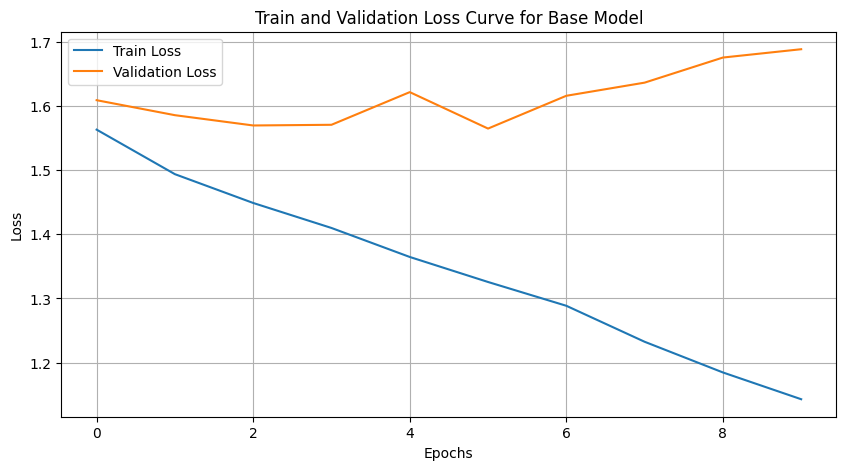

In [10]:
# Plot the loss curve
model.plot_loss_curves(train_losses, val_losses, "Base Model")

# Testing the model

In [11]:
test_acc, test_macro_f1 = model.evaluate_model(test_loader, device)
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test Macro F1: {test_macro_f1:.4f}")

Final Test Accuracy: 0.4920
Final Test Macro F1: 0.2213


# Check predictions

In [12]:
model.emotion_predict(test_dataset)

Utterance: It kicked! I think the baby kicked!
True: surprise | Predicted: neutral

Utterance: So uh, what are you in for?
True: neutral | Predicted: neutral

Utterance: Love is the best medicine.
True: joy | Predicted: neutral

Utterance: There’s just so much pressure.
True: anger | Predicted: sadness

Utterance: No, I don’t.
True: disgust | Predicted: neutral

Utterance: Oh my God! We are throwing the most depressing baby shower ever!
True: sadness | Predicted: anger

Utterance: Sure!
True: joy | Predicted: neutral

